## Skript na vizualizaciu modelov

In [1]:
# Blok 1 - nacitanie kniznic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.utils import np_utils, plot_model
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [2]:
# Blok 2 - Funkcie pre generovanie sumu. Nastavenie pseudo-nahodneho generatora.
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

In [3]:
# Blok 3 - nacitanie dat, vytvorenie pola kriviek a features, pridanie sumu, MinMax normalizacia
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()
data_sample = data.sample(n=100000)

X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

y = np.array(data_sample[[
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2"]])
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.2)

# Adding noise to train data
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

# MinMax Scaler
scaler = MinMaxScaler()
y_minmax_scaled = scaler.fit_transform(y_train_n)
y_minmax_scaled[0]

y_inc = np.array([arr[0] for arr in y_minmax_scaled])
y_mass = np.array([arr[1] for arr in y_minmax_scaled])
y_prim_potent = np.array([arr[2] for arr in y_minmax_scaled])
y_sec_potent = np.array([arr[3] for arr in y_minmax_scaled])
y_temp_ratio = np.array([arr[4] for arr in y_minmax_scaled])

In [6]:
# Blok 4 - zadefinovanie architektury, ktora sa bude vizualizovat
inputs_y = Input(shape=(X_train_n.shape[1], 1))

a = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
a = LSTM(64, return_sequences=True)(a)
a = Flatten()(a)
a = Dense(32, activation='relu')(a)
a = Model(inputs=inputs_y, outputs=a)

b = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
b = MaxPooling1D(2)(b)
b = Conv1D(128, kernel_size = 3, padding = "valid")(b)
b = LSTM(64, return_sequences=True)(b)
b = LSTM(64, return_sequences=True)(b)
b = Flatten()(b)
b = Dense(32, activation='relu')(b)
b = Model(inputs=inputs_y, outputs=b)

c = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
c = MaxPooling1D(2)(c)
c = Conv1D(128, kernel_size = 3, padding = "valid")(c)
c = LSTM(64, return_sequences=True)(c)
c = LSTM(64, return_sequences=True)(c)
c = Flatten()(c)
c = Dense(32, activation='relu')(c)
c = Model(inputs=inputs_y, outputs=c)

d = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
d = MaxPooling1D(2)(d)
d = Conv1D(128, kernel_size = 3, padding = "valid")(d)
d = LSTM(64, return_sequences=True)(d)
d = LSTM(64, return_sequences=True)(d)
d = Flatten()(d)
d = Dense(32, activation='relu')(d)
d = Model(inputs=inputs_y, outputs=d)

e = Conv1D(128, kernel_size = 3, padding = "valid")(inputs_y)
e = MaxPooling1D(2)(e)
e = Conv1D(128, kernel_size = 3, padding = "valid")(e)
e = LSTM(64, return_sequences=True)(e)
e = LSTM(64, return_sequences=True)(e)
e = Flatten()(e)
e = Dense(32, activation='relu')(e)
e = Model(inputs=inputs_y, outputs=e)

x = concatenate([a.output, b.output, c.output, d.output, e.output])
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

output = Dense(5, activation='linear')(x)

model_multi_v5 = Model(inputs=inputs_y, outputs=output)
model_multi_v5.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_multi_v5.summary())

Model: "functional_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 398, 128)     512         input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 398, 128)     512         input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 398, 128)     512         input_6[0][0]                    
______________________________________________________________________________________

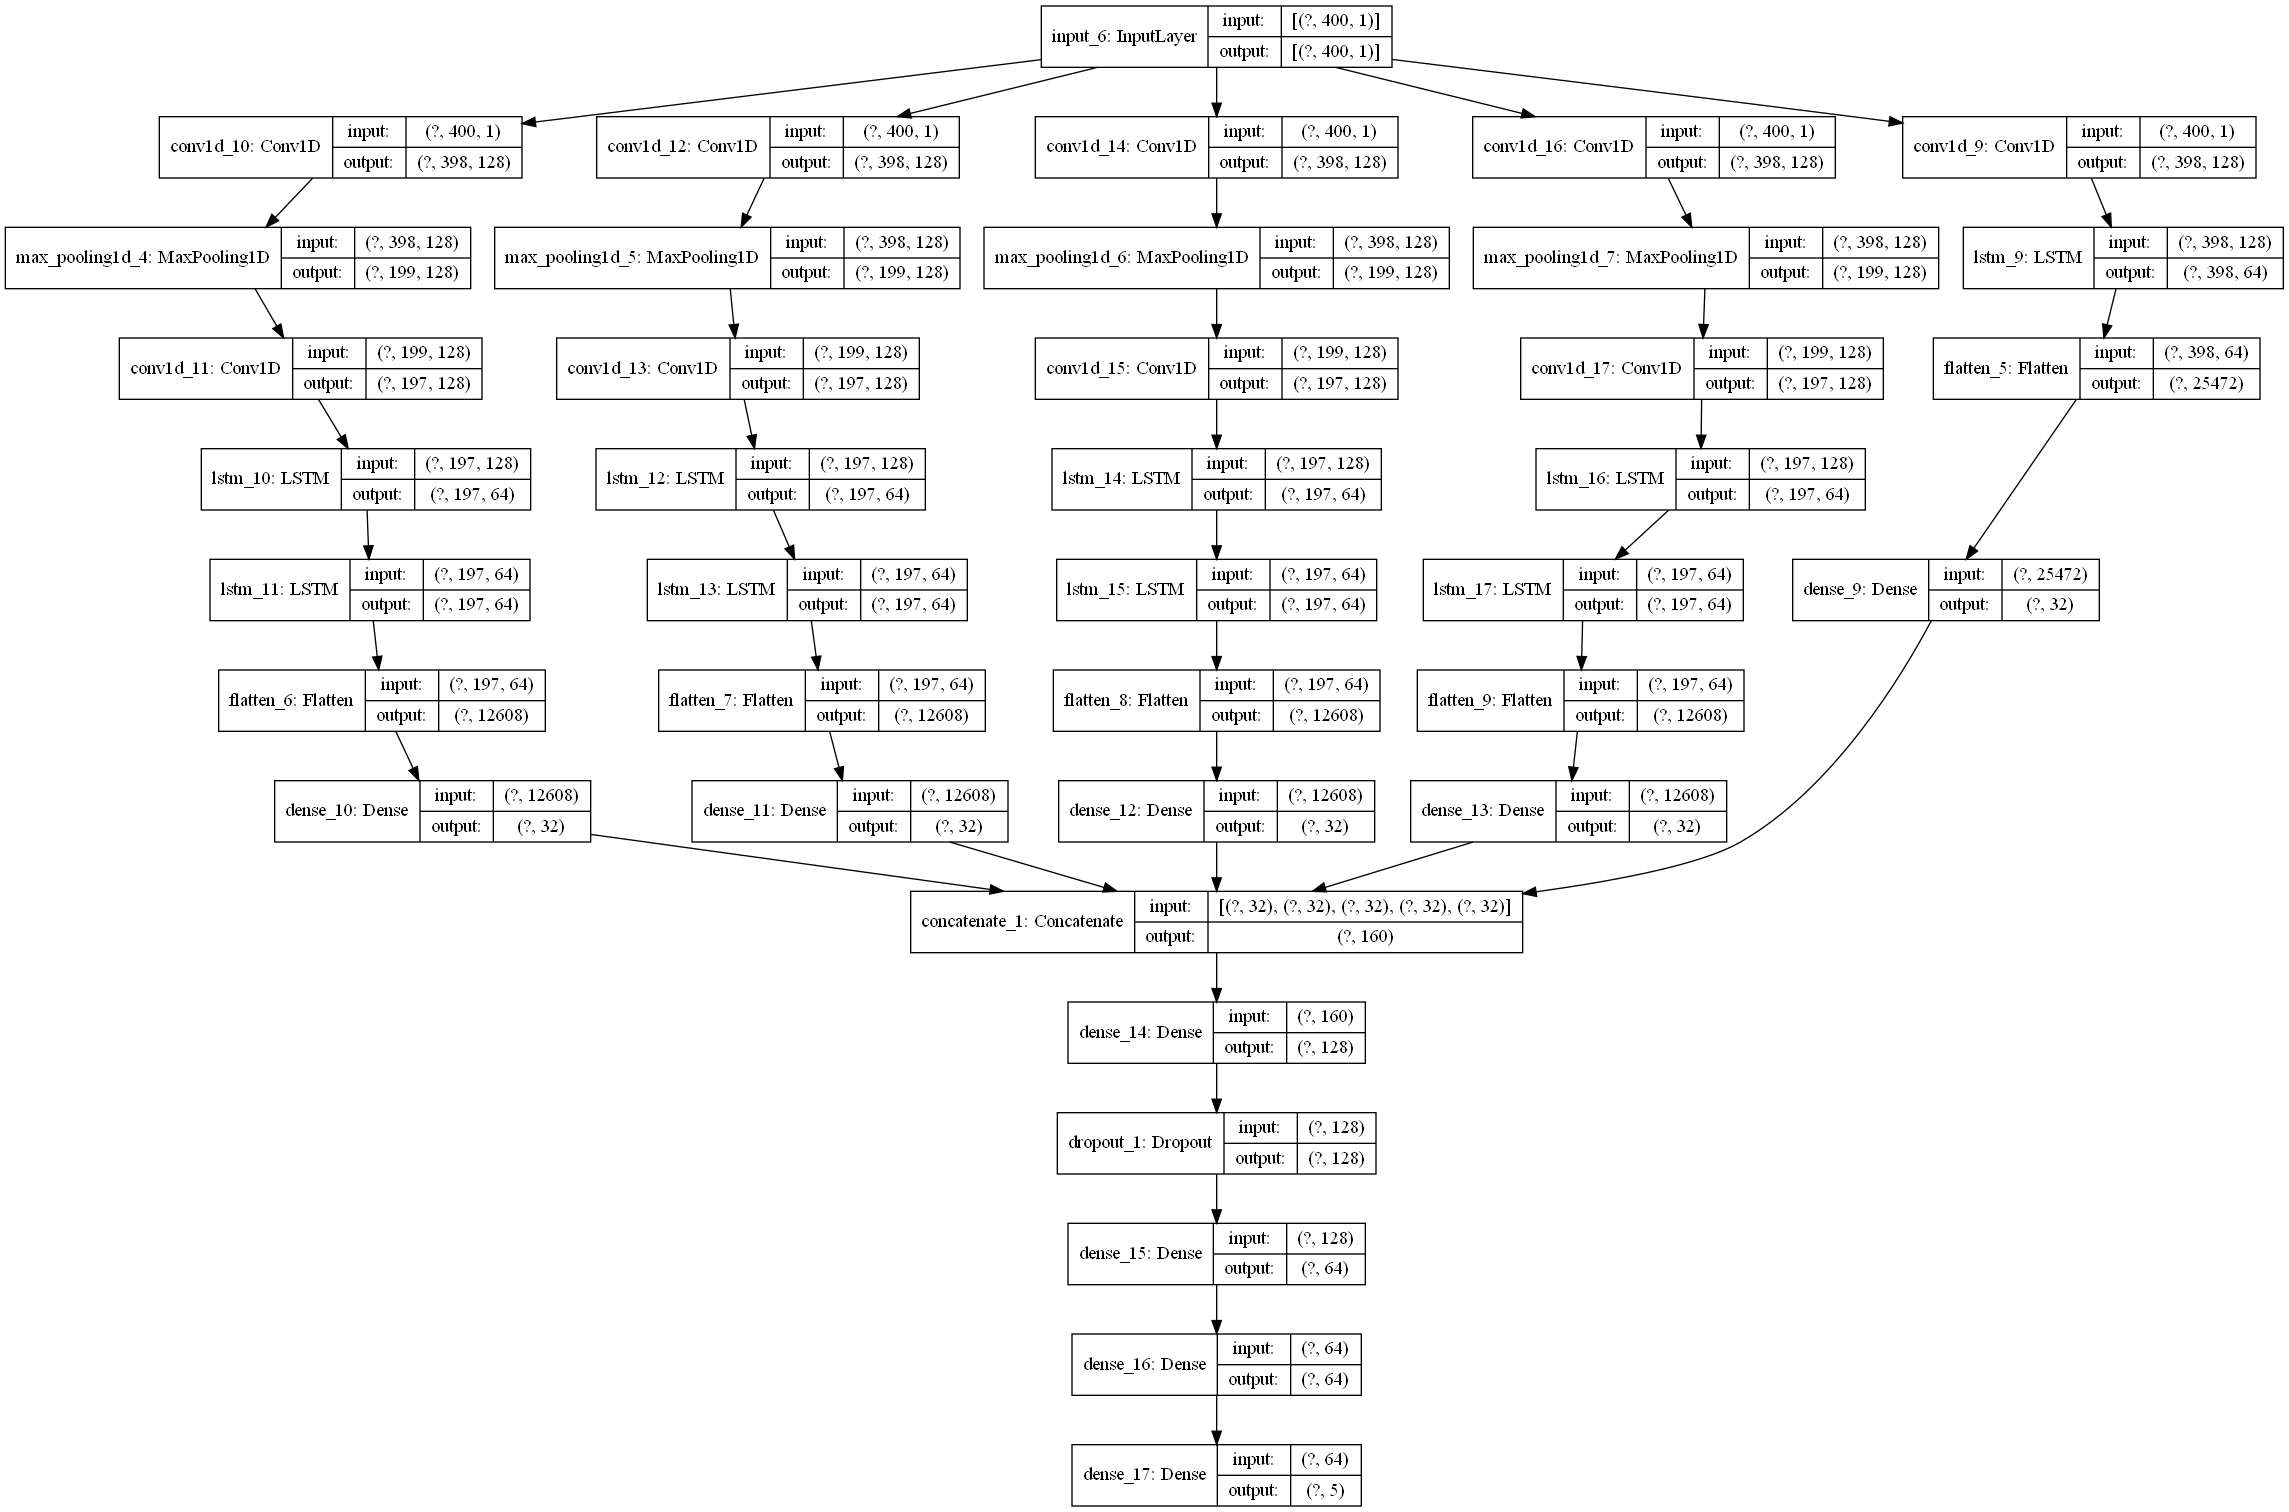

In [7]:
# Blok 5 - vizualizovanie modelu
dot_img_file = 'model_multi_v5.png'
plot_model(model_multi_v5, to_file=dot_img_file, show_shapes=True)